In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import os
from os.path import expanduser
import re

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set();

In [3]:
home = expanduser("~")
path2data = home + '/.kaggle/competitions/recruit-restaurant-visitor-forecasting/'

In [4]:
# folder to save figures
path2figures = 'figures/'
if  not os.path.exists(path2figures): os.mkdir(path2figures)

## Download Dataset

In [5]:
if  not os.path.exists(path2data):
    !pip install kaggle
    !kaggle competitions download -c recruit-restaurant-visitor-forecasting -p ~/.kaggle/competitions/recruit-restaurant-visitor-forecasting
    !cd ~/.kaggle/competitions/recruit-restaurant-visitor-forecasting && ls && unzip "*.zip"
else:
    print('Dataset already downloaded!')

Dataset already downloaded!


In [6]:
!ls {path2data}

air_reserve.csv       date_info.csv         sample_submission.csv
air_store_info.csv    hpg_reserve.csv       store_id_relation.csv
air_visit_data.csv    hpg_store_info.csv


In [7]:
files = glob.glob(path2data + '*.csv')
#files

## Data Loading

In [8]:
dfs = { re.search('/([^/\.]*)\.csv', fn).group(1):
    pd.read_csv(fn)for fn in glob.glob( path2data +'*.csv')}
for k, v in dfs.items(): locals()[k] = v

- **air_store_info** contains information about select air restaurants.

- **air_visit_data** contains historical visit data for the air restaurants. It has basicaly the id of the reservation using the air system, visit_date and the number of visitors. In order to combine the provided informations with the new feature we have created a new structure **visitors**. 

- **hpg_store_info** contains information about select hpg restaurants.

- **hpg_reserve** contains informations abourt reservation made using hpg. 

- **air_reserve** contains informations abourt reservation made using air. 

In [9]:
for k,v in  dfs.items(): print(k)

air_store_info
date_info
store_id_relation
hpg_reserve
air_reserve
air_visit_data
sample_submission
hpg_store_info


### Get train and test data

In [10]:
sample_submission['air_store_id'] = sample_submission.id.map(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['visit_date'] = sample_submission.id.map(lambda x: x.split('_')[2])
sample_submission = sample_submission.drop('id', axis='columns')
sample_submission['visitors'] = np.nan
sample_submission['test_set'] = True

In [11]:
sample_submission.head(3)

,visitors,air_store_id,visit_date,test_set
0,NaN,air_00a91d42b08b08d9,2017-04-23,True
1,NaN,air_00a91d42b08b08d9,2017-04-24,True
2,NaN,air_00a91d42b08b08d9,2017-04-25,True


In [12]:
air_visit_data =  pd.concat((air_visit_data, sample_submission))

In [13]:
air_visit_data.head()

,air_store_id,test_set,visit_date,visitors
0,air_ba937bf13d40fb24,NaN,2016-01-13,25.0
1,air_ba937bf13d40fb24,NaN,2016-01-14,32.0
2,air_ba937bf13d40fb24,NaN,2016-01-15,29.0
3,air_ba937bf13d40fb24,NaN,2016-01-16,22.0
4,air_ba937bf13d40fb24,NaN,2016-01-18,6.0


In [14]:
air_visit_data.shape

(284127, 4)

### Inner join between the two data sources (air and hpg)

**store_id_relation** has the relationship between the two separate sites in which the data comes:
    
Hot Pepper Gourmet (**hpg**): similar to Yelp, here users can search restaurants and also make a reservation online

AirREGI / Restaurant Board (**air**): similar to Square, a reservation control and cash register system

In [15]:
store_id_relation.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [16]:
air_info = air_reserve.merge(air_store_info, on='air_store_id', how='left', suffixes=('', '_y'))

In [17]:
data = air_visit_data.merge(air_store_info, on='air_store_id', how='left', suffixes=('', '_y'))
data = data.merge(store_id_relation, on='air_store_id', how='left', suffixes=('', '_y')) 
data = data.merge(hpg_store_info, on='hpg_store_id', how='left', suffixes=('', '_y'))

In [18]:
data.head(2)

,air_store_id,test_set,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y
0,air_ba937bf13d40fb24,NaN,2016-01-13,25.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
1,air_ba937bf13d40fb24,NaN,2016-01-14,32.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN


**Date info** carry out information about the calendary. Has proposed by [zeemeen](https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st) we have created a new feature **Weight** which creates a ponderation factor around holidays and weekends.

In [19]:
wkend_holidays = date_info.apply(lambda x: (x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and x.holiday_flg==1, axis=1)
wkend_holidays.value_counts()

date_info.loc[wkend_holidays, 'holiday_flg'] = 0
date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5

In [20]:
date_info.head(5)

,calendar_date,day_of_week,holiday_flg,weight
0,2016-01-01,Friday,1,2.707368e-14
1,2016-01-02,Saturday,0,8.663577e-13
2,2016-01-03,Sunday,0,6.578904e-12
3,2016-01-04,Monday,0,2.772345e-11
4,2016-01-05,Tuesday,0,8.460525e-11


The number of visitor which is the target of the problem was transformed used a **log(1 + visitors)**. This transformation brings the distribution of visitors closer to a gaussian distribution which helps convergence 

In [21]:
data = data.merge(date_info, left_on='visit_date', right_on='calendar_date', how='left')
data['visitors_log'] = data.visitors.map(pd.np.log1p)

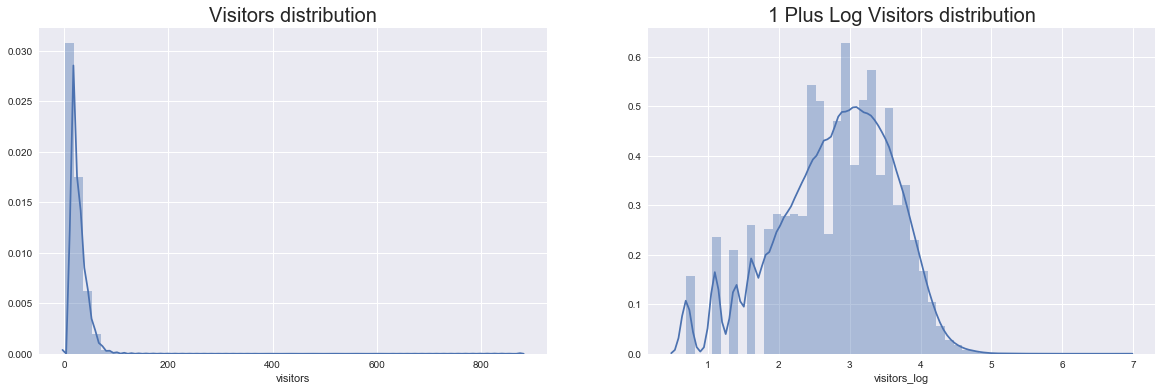

In [22]:
fig = plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.distplot(data[data['visitors'].notnull()]['visitors'])
plt.title('Visitors distribution', fontsize=20)
plt.subplot(1,2,2)
sns.distplot(data[data['visitors'].notnull()]['visitors_log'])
plt.title('1 Plus Log Visitors distribution', fontsize=20)

fig.savefig(path2figures + 'visitor_distribution.png')

In [23]:
data.head(2)

,air_store_id,test_set,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y,calendar_date,day_of_week,holiday_flg,weight,visitors_log
0,air_ba937bf13d40fb24,NaN,2016-01-13,25.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,2016-01-13,Wednesday,0,1.005227e-08,3.258097
1,air_ba937bf13d40fb24,NaN,2016-01-14,32.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,2016-01-14,Thursday,0,1.456087e-08,3.496508


In [24]:
data[data['visitors'].notnull()][['visitors', 'visitors_log']].describe()

,visitors,visitors_log
count,252108.000000,252108.000000
mean,20.973761,2.802788
std,16.757007,0.807726
min,1.000000,0.693147
25%,9.000000,2.302585
50%,17.000000,2.890372
75%,29.000000,3.401197
max,877.000000,6.777647


### Weather informations

In order to create a more robust model, we have used information about the [weather](https://www.kaggle.com/huntermcgushion/rrv-weather-data). The cell bellow will download automatically this dataset. To add the precipitation and avg_temperature it will be used the function [add_weather](https://gist.github.com/superMDguy/72689a11746079677ddb0d19f26443a1) as demonstrated bellow.

In [25]:
path2weather = 'raw/weather/'

In [26]:
if  not os.path.exists(path2weather):
    !wget -O rrv-weather-data.zip "https://storage.googleapis.com/kaggle-datasets/7480/12096/rrv-weather-data.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1528816610&Signature=kDnX2dX3Pd8VGbR6rqRmDH7XYFjBiKYnz3hoez3AWjv0oUf2vJKLpYKV7zfLb%2FgNJE2kXy9D8%2BNvmNkx4LrJHRvVrIMsGyMe%2FM0x1Z3Kxk6nJMSI9BDZGhsyBSONBKPNdND%2FEHuo2k1T2Wo8tOBu1VOOQlLt8NkblTCBx3ihEvEapCq6UgtfNvYvnE55MI8TBCNLcMBBBUU3Cv251yywybyUTAGRfWfIoc2hcYkrVV0j8EtOCfX5CKrAmvxhnuzLBKvlapIrYmOLRtwjlyFfQh2nWqpQGb7ORj%2BUfTvL3trMgOd06aozbCj4A207p%2FBd2IBEweYElxsgddGdpwaLHg%3D%3D"
    !mkdir -p raw/weather/
    !mv rrv-weather-data.zip raw/weather/
    !cd raw/weather/ && unzip rrv-weather-data.zip
    !cd raw/weather/ && unzip 1-1-16_5-31-17_Weather.zip
else:
    print('Weather Dataset already downloaded!')

Weather Dataset already downloaded!


In [27]:
# This is an example of the used weather file
pd.read_csv(path2weather + '1-1-16_5-31-17_Weather/tokyo__tokyo-kana__tonokyo.csv').head()

,calendar_date,avg_temperature,high_temperature,low_temperature,precipitation,hours_sunlight,solar_radiation,deepest_snowfall,total_snowfall,avg_wind_speed,avg_vapor_pressure,avg_local_pressure,avg_humidity,avg_sea_pressure,cloud_cover
0,2016-01-01,7.5,12.1,3.6,NaN,9.0,11.80,NaN,NaN,2.6,4.5,1022.4,45.0,1025.4,2.5
1,2016-01-02,7.3,13.4,2.6,NaN,7.5,11.59,NaN,NaN,1.9,5.2,1018.6,51.0,1021.5,4.3
2,2016-01-03,9.3,16.2,3.0,NaN,8.3,10.77,NaN,NaN,1.4,7.0,1013.2,61.0,1016.2,5.3
3,2016-01-04,9.2,15.2,4.4,NaN,8.9,11.19,NaN,NaN,1.6,6.8,1010.4,60.0,1013.3,0.0
4,2016-01-05,10.9,15.4,5.1,NaN,8.4,10.57,NaN,NaN,1.8,6.5,1013.1,51.0,1016.0,2.8


In [28]:
def add_weather(dataset, path2weather='raw/weather/'):                                                                                                                     
    print('Adding weather...')                                                                                                                
    air_nearest = pd.read_csv(                                                                                                                
        path2weather + 'air_store_info_with_nearest_active_station.csv')                                                              
    unique_air_store_ids = dataset.air_store_id.unique().tolist()                                                                                
                                                                                                                                              
    weather_dir = path2weather + '1-1-16_5-31-17_Weather/'                                                                            
    weather_keep_columns = ['precipitation', 'avg_temperature']                                                                                                                         
                                                                                                                                              
    dataset_with_weather = dataset.copy()                                                                                                     
    for column in weather_keep_columns:                                                                                                       
        dataset_with_weather[column] = np.nan
        
    for air_id in unique_air_store_ids:                                                                                                       
        station = air_nearest[air_nearest.air_store_id == air_id].station_id.iloc[0]  
        weather_data = pd.read_csv(weather_dir + station + '.csv', parse_dates=['calendar_date']).rename(columns={'calendar_date': 'visit_date'})                                                                                                                                               
        
        #change datetime format
        weather_data['visit_date'] = weather_data['visit_date'].dt.strftime('%Y-%m-%d')
        this_store = dataset.air_store_id == air_id                                                                                           
        merged = dataset[this_store].merge(weather_data, on='visit_date', how='left')                                                         
        for column in weather_keep_columns:                                                                                                   
            dataset_with_weather.loc[this_store, column] = merged[column]           
    
    return dataset_with_weather    

In [29]:
air_store_info_with_active_station = pd.read_csv(path2weather + 'air_store_info_with_nearest_active_station.csv')

In [30]:
air_store_info_with_active_station.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,"""35.6580681""","""139.7515992""",tokyo__tokyo-kana__tonokyo,35.691667,139.750000,3.730672,3.739835


In [31]:
data = pd.merge(left=data, right=air_store_info_with_active_station, on='air_store_id', how='left', suffixes=('', '_y'))

In [32]:
data = add_weather(data)

Adding weather...


In [33]:
data.isnull().sum().sum()

2162351

In [34]:
print(f"Percentage of NaN's in precipitation column: {(data[data['precipitation'].isnull()].shape[0]/data.shape[0])*100}")
print(f"Percentage of NaN's in avg_temperature column: {(data[data['avg_temperature'].isnull()].shape[0]/data.shape[0])*100}")

Percentage of NaN's in precipitation column: 99.92820112132955
Percentage of NaN's in avg_temperature column: 99.8623854825483


I will try to complete this analysis over this week.

In [35]:
# Handle missing data
# We could replace this block by the avg_temperature and precipitation of stations which are closer

data['precipitation'].fillna(data.precipitation.mean(), inplace=True)
data['avg_temperature'].fillna(data.avg_temperature.mean(), inplace=True)

In [36]:
def drop_y(df):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in df if x.endswith('_y')]
    df.drop(to_drop, axis=1, inplace=True)
    return df

In [37]:
data = drop_y(data)

### Extract informations about the spatial location of the restaurant
    - Todofuken
    - city
    - street

In [38]:
area  = data.air_area_name.str.split(' ', expand=True)

data['Todofuken'] = area[0]
data['city'] = area[1]
data['street'] = area.iloc[:, 2:].apply(lambda row: ' '.join(row.dropna()), axis=1)

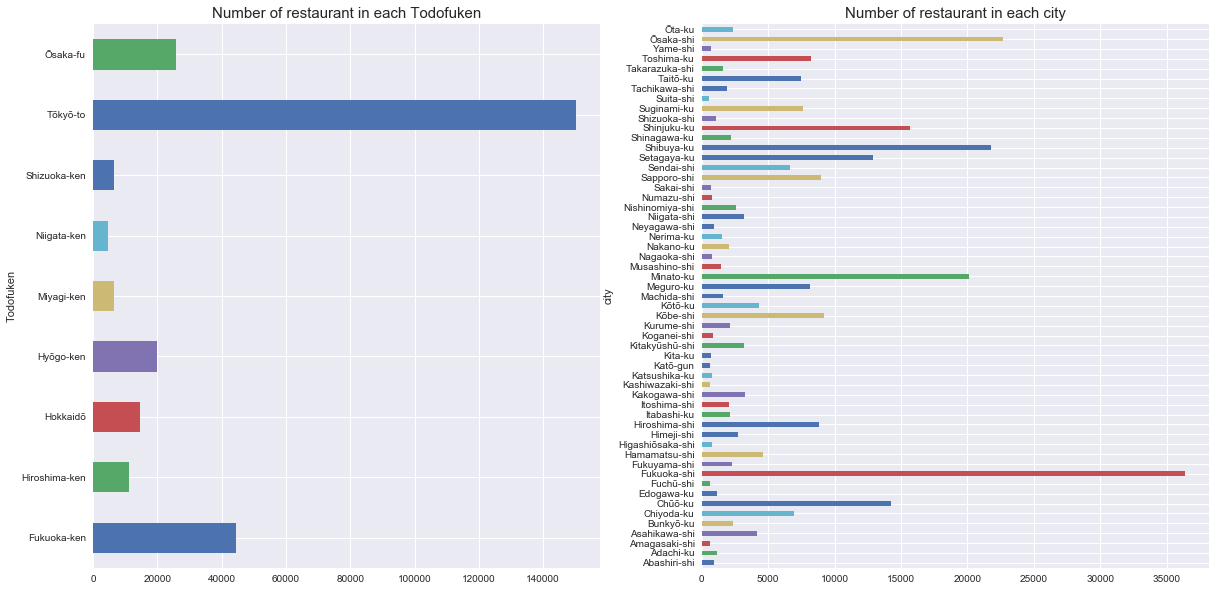

In [39]:
fig = plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
data.groupby(['Todofuken']).size().plot(kind = 'barh')
plt.title('Number of restaurant in each Todofuken', fontsize=15)

plt.subplot(1,2,2)
data.groupby(['city']).size().plot(kind = 'barh')
plt.title('Number of restaurant in each city', fontsize=15)
          
fig.savefig(path2figures + 'stores_distribution.png')

### Obtain informations about reservations

In [40]:
#air_reserve['visit_datetime'] = air_reserve.visit_datetime.astype('datetime64[ns]')
#air_reserve['reserve_ahead'] = air_reserve.visit_datetime.astype('datetime64[ns]') - air_reserve.reserve_datetime.astype('datetime64[ns]')
#air_reserve['reserve_ahead_seconds'] = air_reserve['reserve_ahead'].apply(lambda x: x.seconds)

Solution propsed using pandas.to_datetime objects.

In [41]:
air_reserve['visit_datetime'] = pd.to_datetime(air_reserve.visit_datetime)
air_reserve['reserve_datetime'] = pd.to_datetime(air_reserve.reserve_datetime)

In [42]:
air_reserve[['reserve_datetime','visit_datetime']].describe()

,reserve_datetime,visit_datetime
count,92378,92378
unique,7513,4975
top,2016-11-24 18:00:00,2016-12-24 19:00:00
freq,106,255
first,2016-01-01 01:00:00,2016-01-01 19:00:00
last,2017-04-22 23:00:00,2017-05-31 21:00:00


In [44]:
air_reserve['reserve_ahead'] =  air_reserve['visit_datetime']- air_reserve['reserve_datetime']
air_reserve['reserve_ahead_seconds'] = air_reserve['reserve_ahead'].dt.total_seconds()

In [45]:
air_reserve.loc[0,'reserve_ahead'],air_reserve.loc[0,'reserve_ahead_seconds']

(Timedelta('0 days 03:00:00'), 10800.0)

In [47]:
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,reserve_ahead,reserve_ahead_seconds
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,03:00:00,10800.0
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,00:00:00,0.0
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,00:00:00,0.0
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,04:00:00,14400.0
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,19:00:00,68400.0


In [52]:
#This difference will cause a lot of NaN values on the features created
air_reserve.shape,data.shape

((92378, 6), (284127, 28))

In [53]:
data['visit_date']= pd.to_datetime(data['visit_date'])

data  =  pd.merge(left=data,  right=air_reserve, how='left', 
                left_on=['visit_date','air_store_id'], 
                right_on=['visit_datetime','air_store_id'])

In [54]:
air_reserve.shape,data.shape

((92378, 6), (284224, 33))

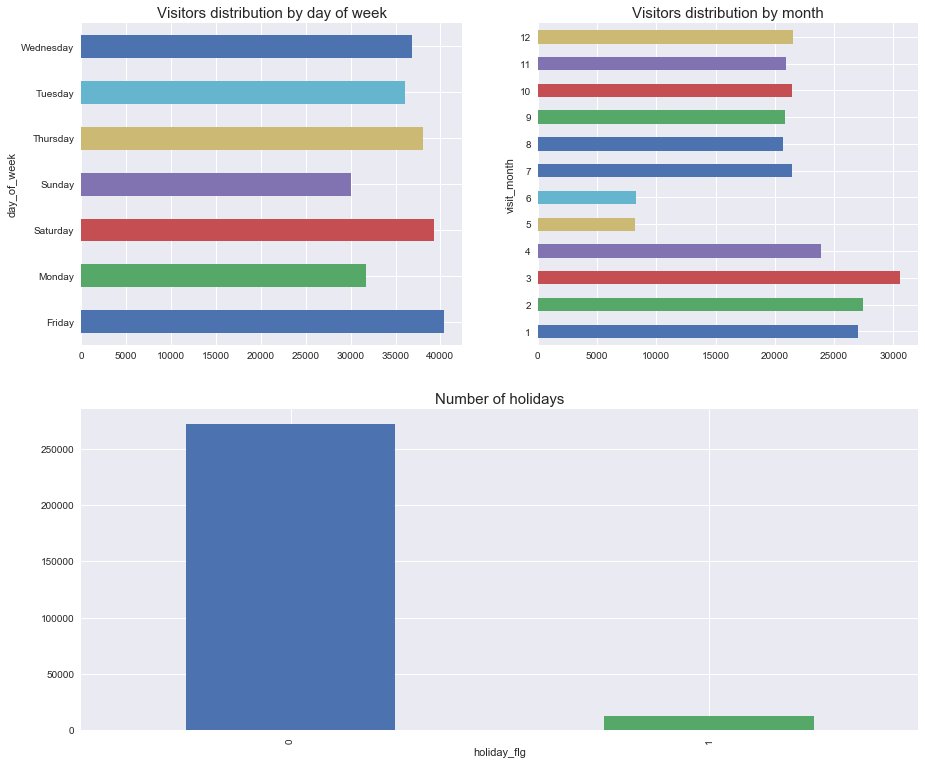

In [55]:
fig = plt.figure(figsize=(15,13))
plt.subplot(2,2,1)
plt.title('Visitors distribution by day of week', fontsize=15)
data.groupby('day_of_week')['visitors'].count().plot(kind = 'barh')

plt.subplot(2,2,2)
plt.title('Visitors distribution by month', fontsize=15)
data['visit_month']= data['visit_date'].dt.month
data.groupby('visit_month')['visitors'].count().plot(kind = 'barh')

plt.subplot(2,2,(3,4))
plt.title('Number of holidays', fontsize=15)
data.groupby('holiday_flg').size().plot(kind = 'bar')

fig.savefig(path2figures + 'visitor_distribution_period.png')

In [57]:
print('Dataset shape: {}'.format(data.shape))

Dataset shape: (284224, 34)


In [58]:
data.head(2)

,air_store_id,test_set,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,...,avg_temperature,Todofuken,city,street,visit_datetime,reserve_datetime,reserve_visitors,reserve_ahead,reserve_ahead_seconds,visit_month
0,air_ba937bf13d40fb24,NaN,2016-01-13,25.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,4.3,Tōkyō-to,Minato-ku,Shibakōen,NaT,NaT,NaN,NaT,NaN,1
1,air_ba937bf13d40fb24,NaN,2016-01-14,32.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,6.0,Tōkyō-to,Minato-ku,Shibakōen,NaT,NaT,NaN,NaT,NaN,1


In [59]:
# Set of cols which are redundat in the dataset, since they were used to obtain other features
redundant_col = ['air_area_name', 'hpg_area_name', 'calendar_date', 
            'latitude_str', 'longitude_str', 'station_latitude', 'station_longitude',
           'station_vincenty', 'station_great_circle',
           'reserve_datetime', 'reserve_ahead', 'air_store_id', 'hpg_store_id', 'station_id']

# Set of cols discarded in the analysis
drop_col = ['street', 'hpg_genre_name', 'visitors', 'visit_datetime','visit_month']

In [60]:
data.drop(redundant_col, axis='columns',inplace=True)
data.drop(drop_col, axis='columns',inplace=True)

In [61]:
print('Features shape: {}'.format(data.shape))

Features shape: (284224, 15)


# Adding date appart features

In [62]:
from regression_utils import add_datepart

add_datepart(data,'visit_date',drop=False)

Using TensorFlow backend.


In [63]:
data.drop('day_of_week',axis=1,inplace=True)
print('Features shape: {}'.format(data.shape))

Features shape: (284224, 27)


## Data attributes description

In [64]:
print('Atributs of the data: {}'.format(data.keys().values))

Atributs of the data: ['test_set' 'visit_date' 'air_genre_name' 'latitude' 'longitude'
 'holiday_flg' 'weight' 'visitors_log' 'precipitation' 'avg_temperature'
 'Todofuken' 'city' 'reserve_visitors' 'reserve_ahead_seconds' 'visit_Year'
 'visit_Month' 'visit_Week' 'visit_Day' 'visit_Dayofweek' 'visit_Dayofyear'
 'visit_Is_month_end' 'visit_Is_month_start' 'visit_Is_quarter_end'
 'visit_Is_quarter_start' 'visit_Is_year_end' 'visit_Is_year_start'
 'visit_Elapsed']


**Target**:
- visitors_log;

**Inputs**
- test_set;
- air_genre_name;
- latitude;
- longitude;
- hpg_genre_name;
- holiday_flg;
- weight;
- station_id;
- precipitation;
- avg_temperature;
- Todofuken;
- city;
- reserve_visitors;
- reserve_ahead_seconds;
- Related to the visit date: 
    - visit_Year;
    - visit_Month;
    - visit_Week;
    - visit_Day;
    - visit_Dayofweek;
    - visit_Dayofyear;
    - visit_Is_month_end;
    - visit_Is_month_start;
    - visit_Is_quarter_end;
    - visit_Is_quarter_start;
    - visit_Is_year_end;
    - visit_Is_year_start;
    - visit_Elapsed;



## LabelEncoder encondig

Encode categorical features: **Todofuken**, **city**, **street**, **air_genre_name**, **hpg_genre_name**.

In [65]:
from sklearn.preprocessing import LabelEncoder

dummies_col = ['Todofuken', 'city', 'air_genre_name']

for column in dummies_col:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column]).tolist()

In [66]:
print('Features shape: {}'.format(data.shape))

Features shape: (284224, 27)


## Split data in train, valid and test set

In [67]:
# sort all data (train and test set)
data.sort_values(by='visit_date',inplace=True)
data.drop('visit_date', axis='columns',inplace=True)

In [68]:
val_size = 0.2
train_aux = data[data['test_set'].isnull()]
train_aux = train_aux.drop(['test_set'], axis='columns') 

In [69]:
def split_by_factor(data, val_size=0.2):
    # adapted forom split_by_date function from regression_utils file 
    # main diference is that te sort_values must be performed in the whole dataset(train+test)
    split= 1 - val_size
    tr,val = np.split(data,[int(len(data)*split)])    
    return tr,val 

In [70]:
train, valid = split_by_factor(train_aux)
test = data[data['test_set'].notnull()]

In [ ]:
# By using the approach below we don't need to divide in train_x and train_y, this saves us memory :]  


#train_x, train_y = train.loc[:, train.columns != 'visitors_log'], train.loc[:, 'visitors_log']
#valid_x, valid_y = valid.loc[:, valid.columns != 'visitors_log'], valid.loc[:, 'visitors_log']
#test_x  = test.loc[:, test.columns != 'visitors_log']

In [81]:
# For now let's drop precipitation and avg_temperature from predictors until we define a better weather feature
# Also let's remove for now reserve_ahead_seconds and reserve_visitors (only 270 non-null values)

predictors = [x for x in train.columns if x not in ['visitors_log','avg_temperature','precipitation',
                                                    'reserve_ahead_seconds','reserve_visitors'] ]
target = 'visitors_log'

# Features Analysis

In [82]:
train[predictors].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201763 entries, 121681 to 176928
Data columns (total 20 columns):
air_genre_name            201763 non-null int64
latitude                  201763 non-null float64
longitude                 201763 non-null float64
holiday_flg               201763 non-null int64
weight                    201763 non-null float64
Todofuken                 201763 non-null int64
city                      201763 non-null int64
visit_Year                201763 non-null int64
visit_Month               201763 non-null int64
visit_Week                201763 non-null int64
visit_Day                 201763 non-null int64
visit_Dayofweek           201763 non-null int64
visit_Dayofyear           201763 non-null int64
visit_Is_month_end        201763 non-null bool
visit_Is_month_start      201763 non-null bool
visit_Is_quarter_end      201763 non-null bool
visit_Is_quarter_start    201763 non-null bool
visit_Is_year_end         201763 non-null bool
visit_Is_year_start

In [89]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=40, min_samples_leaf=10, max_features='auto',
                             n_jobs=-1, oob_score=True,random_state=0)

In [90]:
reg.fit(train[predictors],train[target])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=0, verbose=0, warm_start=False)

In [92]:
from regression_utils import print_score
print_score(reg,train[predictors],train[target],valid[predictors],valid[target])

 Train Score:
RMSE: 0.638415, MAE: 0.499274
Oob score : 0.212427
------------------------------
 Val Score:
RMSE: 0.708803, MAE: 0.562716


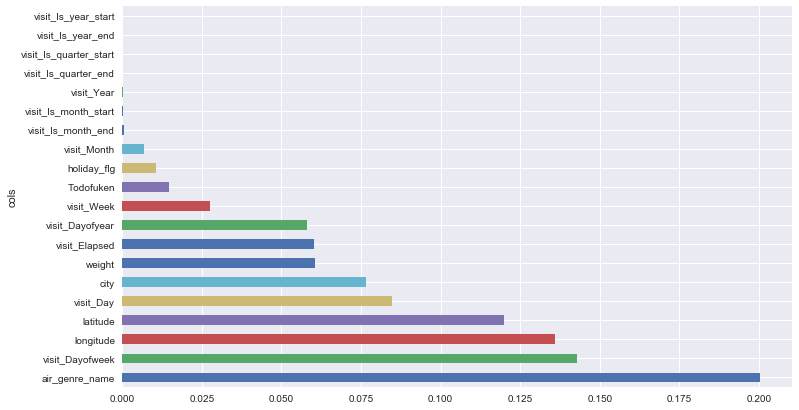

In [93]:
from regression_utils import rf_feat_importance,plot_fi

fi = rf_feat_importance(reg, train[predictors])
plot_fi(fi[:40]);

In [98]:
to_keep = fi[fi.imp>1e-2].cols.tolist(); len(to_keep),len(predictors)

(12, 20)

In [99]:
reg.fit(train[to_keep],train[target])
print_score(reg,train[to_keep],train[target],valid[to_keep],valid[target])

 Train Score:
RMSE: 0.638425, MAE: 0.499277
Oob score : 0.212427
------------------------------
 Val Score:
RMSE: 0.708929, MAE: 0.562853


In [100]:
# The results of RMSE and Oob score didn't change much droping the 8 features using the threshold of
# feature importances, let's try one more time 

In [102]:
predictors = to_keep.copy()

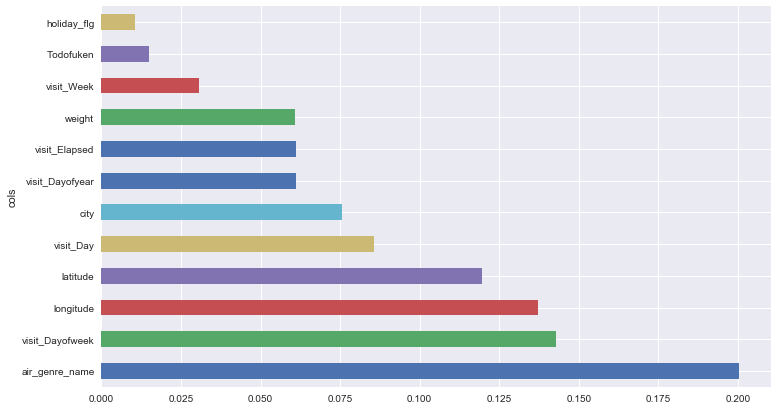

In [103]:
fi = rf_feat_importance(reg, train[predictors])
plot_fi(fi[:40]);

In [106]:
to_keep = fi[fi.imp>2e-2].cols.tolist(); len(to_keep),len(predictors)

(10, 12)

In [107]:
reg.fit(train[to_keep],train[target])
print_score(reg,train[to_keep],train[target],valid[to_keep],valid[target])

 Train Score:
RMSE: 0.639073, MAE: 0.499928
Oob score : 0.209959
------------------------------
 Val Score:
RMSE: 0.710233, MAE: 0.563740


In [108]:
# Now we got an improvement so let's keep this 10 features for a while and run the models.

In [114]:
predictors = to_keep.copy()

# Predictive modelling

## Decision Trees

Since XGBoost already does feature selection using gamma, we could also try using whole set of features 
and optimize gamma for that

In [115]:
from regression_utils import cross_valid
import xgboost as xgb

def xgbCV(gamma,
          min_child_weight,
          colsample_bytree,subsample):

    reg = xgb.sklearn.XGBRegressor(gamma=max(gamma, 0),
                                    max_depth= 10,
                                    min_child_weight= int(min_child_weight),
                                    subsample = max(min(subsample, 1), 0),
                                    colsample_bytree= max(min(colsample_bytree, 1), 0),
#                                    reg_lambda= max(reg_lambda, 0), 
                                    n_estimators=100,
                                    n_jobs=7)

    score = cross_valid(reg,train[predictors +[target]].values,folds=5,
                        metric='rmse',verbose=False)

    res = np.mean(score)/(1+np.std(score)) # 1/std -> For reducing the variance between folds 
    return -res  # Negative because we want to minimize score and BayesianOptimization only maximize scores

In [116]:
from bayes_opt import BayesianOptimization
#https://github.com/fmfn/BayesianOptimization

In [117]:
gp_params = {"alpha": 1e-5,"n_restarts_optimizer": 2}

xgbBO = BayesianOptimization(xgbCV, {'min_child_weight': (1, 40),
                                     'subsample': (0.2, 1),
                                     'colsample_bytree': (0.7, 1),
                                     'gamma': (0, 18),
#                                     'reg_lambda': (1, 10),
                                    })

In [118]:
xgbBO.maximize(init_points=4,n_iter=24, acq="ei", xi=1e-2, **gp_params)

Initialization
-------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   min_child_weight |   subsample | 
    1 | 00m47s |   -0.69952 |             0.7822 |    5.5637 |            23.8249 |      0.8477 | 
    2 | 00m51s |   -0.70411 |             0.9425 |    1.9019 |            38.0029 |      0.2204 | 
    3 | 00m47s |   -0.70167 |             0.7172 |    7.8706 |             6.4215 |      0.9189 | 
    4 | 00m54s |   -0.69611 |             0.7564 |    0.4539 |            35.7835 |      0.5648 | 
Bayesian Optimization
-------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   min_child_weight |   subsample | 
    5 | 01m06s |   -0.71644 |             0.9175 |   17.9850 |             1.0022 |      0.4206 | 
    6 | 01m13s |   -0.69826 |             0.9799 |    0.0587 |            

/anaconda/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  1.75330573e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


   26 | 00m47s |   -0.70990 |             0.9920 |   17.9040 |            20.5340 |      0.9983 | 
   27 | 00m42s |   -0.69197 |             0.7300 |    0.1095 |            39.6012 |      0.9805 | 
   28 | 00m43s |   -0.69172 |             0.7084 |    0.0481 |             1.4359 |      0.9910 | 


In [ ]:
# Intersting to notice that the gamma value was really low for the best solutions, which means that our feature
# selection process with Oob_score worked! :]

In [119]:
xgbBO.res['max']['max_val']

-0.68887224514357936

In [120]:
paramsBO = xgbBO.res['max']['max_params']
paramsBO

{'colsample_bytree': 0.99567342269583392,
 'gamma': 0.19246739099569932,
 'min_child_weight': 15.491987773299941,
 'subsample': 0.97514082858831919}

In [121]:
reg = xgb.sklearn.XGBRegressor(gamma=max(paramsBO['gamma'], 0),
                                max_depth= 10,
                                min_child_weight= int(paramsBO['min_child_weight']),
                                subsample =  max(min(paramsBO['subsample'], 1), 0),#1,
                                colsample_bytree= max(min(paramsBO['colsample_bytree'], 1), 0),
#                                reg_lambda= max(paramsBO['reg_lambda'], 0),
                                n_jobs=7, 
                                n_estimators=300) # Get some more trees

reg.fit(train[predictors],train[target]) # Fit best Model on whole train data 
                                         # If you want to see the results from the cross-val you run the function 
                                         # with verbose = True

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.99567342269583392, gamma=0.19246739099569932,
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=15, missing=None, n_estimators=300, n_jobs=6,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.97514082858831919)

In [122]:
ypred = reg.predict(train[predictors])
ytrue= train[target].values

ytrue.shape,ypred.shape

((201763,), (201763,))

In [125]:
from sklearn.metrics import mean_absolute_error as mae
from regression_utils import rmse

mae(ytrue,ypred),rmse(ytrue,ypred)

(0.4973765220494592, 0.63666936652813333)

In [126]:
ypred = reg.predict(valid[predictors])
ytrue= valid[target].values

ytrue.shape,ypred.shape

((50441,), (50441,))

In [127]:
mae(ytrue,ypred),rmse(ytrue,ypred)

(0.56534846718016962, 0.71401428345095819)

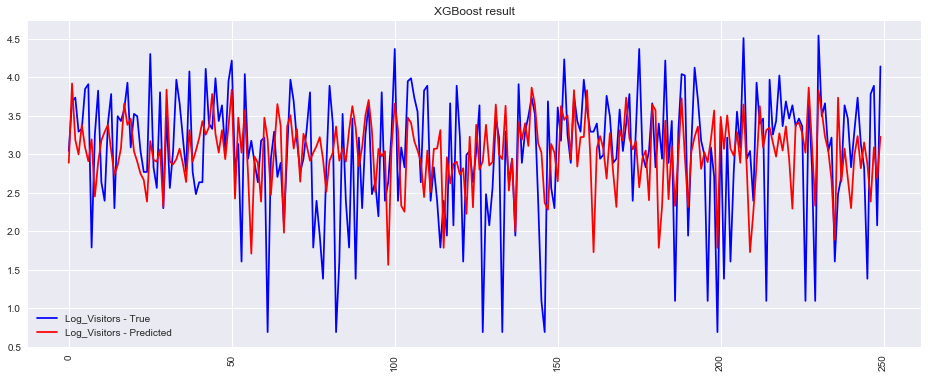

In [129]:
n_samples = 250
fig = plt.figure(figsize=(16,6))     

plt.plot(ytrue[:n_samples], c = 'blue',label='Log_Visitors - True')

plt.plot(ypred[:n_samples], c = 'red', label='Log_Visitors - Predicted')


plt.xticks(rotation=90)
#plt.xscale('log')
plt.title('XGBoost result')
plt.xlabel('')
plt.ylabel('')
#plt.ylim([-25e-6,25e-6])
plt.grid('on')
plt.legend()
plt.show()

## ANN 

In [302]:
#Let's use all features 
predictors = [x for x in train.columns if x not in ['visitors_log','avg_temperature','precipitation',
                                                    'reserve_ahead_seconds','reserve_visitors'] ]

In [434]:
# Feature Scaling

scaled= train[predictors+[target]].copy()
scaled_valid= valid[predictors+[target]].copy()
scaled_test = test[predictors].copy()

In [435]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
#sc1 = MinMaxScaler(feature_range=(0,1),copy=False)
sc1 = StandardScaler(copy=False)
#sc1 = RobustScaler()

In [436]:
scaled[predictors] = sc1.fit_transform(scaled[predictors])
scaled_test[predictors] = sc1.transform(scaled_test[predictors])
scaled_valid[predictors] = sc1.transform(scaled_valid[predictors])

In [437]:
len(predictors)

20

In [508]:
from regression_utils import MLP_Regressor

mlp = MLP_Regressor(n_estimators=[20,40,20],dp=None,
                    input_dim= len(predictors))

In [509]:
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_95 (Dense)             (None, 40)                840       
_________________________________________________________________
dense_96 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_97 (Dense)             (None, 1)                 21        
Total params: 2,101
Trainable params: 2,101
Non-trainable params: 0
_________________________________________________________________


In [510]:
from keras.optimizers import Adam,RMSprop

opt = Adam(lr = 1e-3,decay=1e-5)
mlp.compile(loss='mae',
              optimizer=opt,)

In [511]:
import os
model_name = "./Recruit_Visitors.hdf5"
reset=True
if reset and os.path.exists(model_name):
    os.remove(model_name)    

In [512]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from clr_callback import CyclicLR  # Cyclical Learning Rate #https://github.com/bckenstler/CLR

In [513]:
scaled.shape

(201763, 21)

In [514]:
epochs= 500
batch_size = 1500

#Learning rate Policies:
clr  = CyclicLR(base_lr=1e-3,max_lr=6e-3,mode="exp_range",step_size= 270.0)

stepLR = ReduceLROnPlateau(factor=0.75,patience=10,min_lr=1e-9,verbose=1)

# Callbacks list
cb = [EarlyStopping(monitor='val_loss',patience=30,verbose=1,mode='min'), 
      ModelCheckpoint(filepath=model_name, monitor='val_loss', verbose=0, save_best_only=True,save_weights_only=True),
      stepLR]

In [515]:
history = mlp.fit(scaled[predictors].values,scaled[target].values,
                   epochs = epochs, batch_size = batch_size,
                   verbose= 1, validation_data=(scaled_valid[predictors].values,scaled_valid[target].values),
                   callbacks=cb)

Train on 201763 samples, validate on 50441 samples
Epoch 1/500
201763/201763 [==============================] - 2s 12us/step - loss: 1.0886 - val_loss: 0.8533
Epoch 2/500
201763/201763 [==============================] - 1s 5us/step - loss: 0.6594 - val_loss: 0.8083
Epoch 3/500
201763/201763 [==============================] - 1s 5us/step - loss: 0.6386 - val_loss: 0.8018
Epoch 4/500
201763/201763 [==============================] - 1s 5us/step - loss: 0.6313 - val_loss: 0.7452
Epoch 5/500
201763/201763 [==============================] - 1s 5us/step - loss: 0.6281 - val_loss: 0.7503
Epoch 6/500
201763/201763 [==============================] - 1s 5us/step - loss: 0.6257 - val_loss: 0.7776
Epoch 7/500
201763/201763 [==============================] - 1s 5us/step - loss: 0.6242 - val_loss: 0.7311
Epoch 8/500
201763/201763 [==============================] - 1s 5us/step - loss: 0.6230 - val_loss: 0.7036
Epoch 9/500
201763/201763 [==============================] - 1s 5us/step - loss: 0.6218 - va

Epoch 74/500
201763/201763 [==============================] - 1s 5us/step - loss: 0.5933 - val_loss: 0.6847
Epoch 75/500
201763/201763 [==============================] - 1s 6us/step - loss: 0.5931 - val_loss: 0.6758
Epoch 76/500
201763/201763 [==============================] - 1s 6us/step - loss: 0.5927 - val_loss: 0.6795
Epoch 77/500
201763/201763 [==============================] - 1s 6us/step - loss: 0.5929 - val_loss: 0.6758
Epoch 00077: early stopping


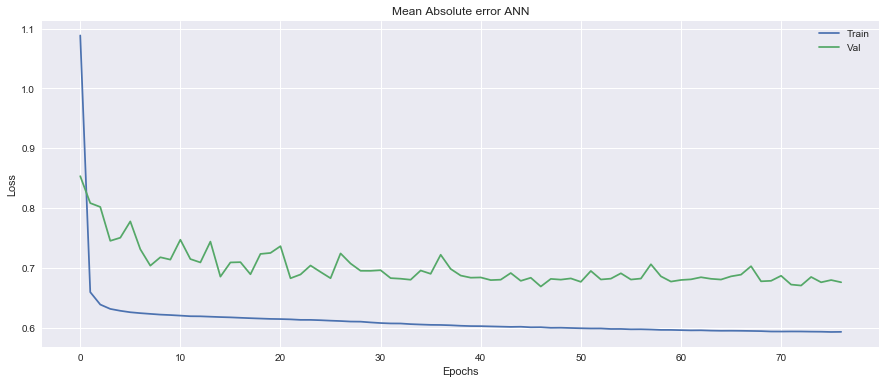

In [516]:
fig = plt.figure(figsize=(15,6))
plt.plot(history.history["loss"],label="Train") 
plt.plot(history.history["val_loss"],label="Val")
#plt.ylim(0.6,1.2) 
plt.title('Mean Absolute error ANN')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.grid(True)

plt.show()

In [517]:
# Getting weights from best epoch
mlp.load_weights(model_name)

opt = Adam(lr = 1e-3)

mlp.compile(loss='mae',
              optimizer=opt)

In [518]:
y_pred = mlp.predict(scaled[predictors].values,batch_size=batch_size,verbose=0)
y_true = scaled[target].values.reshape(-1,1)

In [519]:
mae(y_true,y_pred),rmse(y_true,y_pred)

(0.59974286681328814, 0.76279143119271897)

In [520]:
#Validation
mlp.evaluate(scaled_valid[predictors].values,scaled_valid[target].values,verbose=1)

50441/50441 [==============================] - 3s 66us/step


0.66873754354598192

In [521]:
#mlp.save_weights('./MAE_0.6423_Recruit_log1p.hdf5')

y_pred = mlp.predict(scaled_valid[predictors].values,batch_size=batch_size,verbose=0)
y_true = scaled_valid[target].values.reshape(-1,1)

In [522]:
mae(y_true,y_pred),rmse(y_true,y_pred)

(0.66873754729291113, 0.84850662606376159)

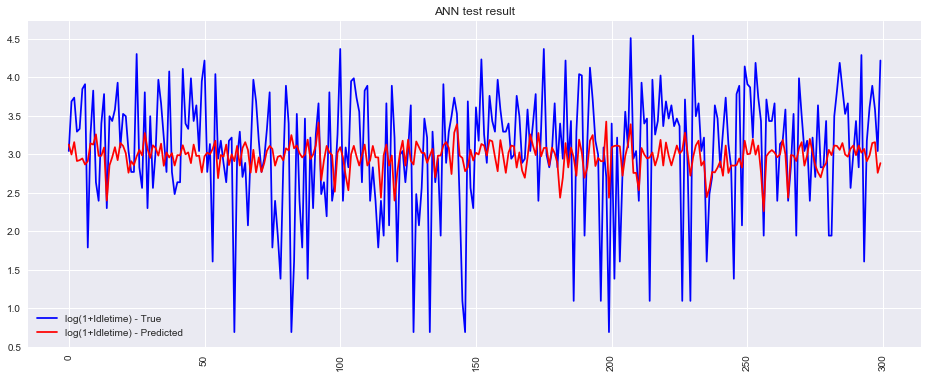

In [523]:
n_samples = 300
fig = plt.figure(figsize=(16,6))     

plt.plot(y_true[:n_samples], c = 'blue',label='log(1+Idletime) - True')

plt.plot(y_pred[:n_samples], c = 'red', label='log(1+Idletime) - Predicted')


plt.xticks(rotation=90)
#plt.xscale('log')
plt.title('ANN test result')
plt.xlabel('')
plt.ylabel('')
#plt.ylim([-25e-6,25e-6])
plt.grid('on')
plt.legend()
plt.show()

### Create and submit prediction

In [ ]:
test[['id', 'visitors']].to_csv('xgboost_submission.csv', index=False, float_format='%.3f') 

In [ ]:
!kaggle competitions submit -c recruit-restaurant-visitor-forecasting -f xgboost_submission.csv -m "xgboost model"